# Demonstration of performing ORIGAMI MOX spent fuel analysis based on SFCOMPO data

In [1]:
nreal=300
print(f"Performing {nreal} power variation realizations")

Performing 300 power variation realizations


In [2]:
%reload_ext autoreload
%autoreload 2
import sys
import scale.olm as olm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import copy

In [13]:
scale_path = '/Users/Shared/ornldev/code/scale/builds/master/INSTALL'

In [14]:
power_calibration = 0.9525985460396809 #1.0 to turn off calibration
print('important power calibration:',power_calibration)

important power calibration: 0.9525985460396809


In [15]:
file = Path('data/Beznau-1_M308_K7_BM5_sample_burnup.txt')
with open(file,'r') as input:
    time0,burnup0,burnup_std0 = olm.contrib.parse_sfcompo_operating_history(input)

2023-10-09 18:35:52 [warning  ] The cumulative burnup decreased from 9719.0 to 0.0 which is impossible. Setting to 9719.0.
2023-10-09 18:35:52 [warning  ] The cumulative burnup decreased from 9719.0 to 0.0 which is impossible. Setting to 9719.0.
2023-10-09 18:35:52 [warning  ] The cumulative burnup decreased from 19515.0 to 0.0 which is impossible. Setting to 19515.0.
2023-10-09 18:35:52 [warning  ] The cumulative burnup decreased from 19515.0 to 0.0 which is impossible. Setting to 19515.0.
2023-10-09 18:35:52 [warning  ] The cumulative burnup decreased from 25834.0 to 0.0 which is impossible. Setting to 25834.0.
2023-10-09 18:35:52 [warning  ] The cumulative burnup decreased from 25834.0 to 0.0 which is impossible. Setting to 25834.0.
2023-10-09 18:35:52 [warning  ] The cumulative burnup decreased from 38658.0 to 0.0 which is impossible. Setting to 38658.0.
2023-10-09 18:35:52 [warning  ] The cumulative burnup decreased from 38658.0 to 0.0 which is impossible. Setting to 38658.0.
2023

1193


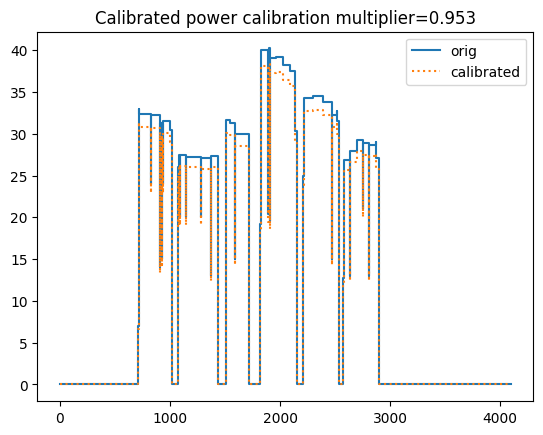

In [16]:
from datetime import datetime
#Date of shutdown
d1 = '1996-06-27'
#Date Am241 separated
d2 = '1999-10-03'
dt1 = datetime.strptime(d1,'%Y-%m-%d')
dt2 = datetime.strptime(d2,'%Y-%m-%d')
delta = dt2 - dt1
#Calculate
decay_until_meas=delta.days
print(decay_until_meas)

time=copy.deepcopy(time0)
burnup=copy.deepcopy(burnup0)
time.append(time0[-1]+decay_until_meas)
burnup.append(burnup0[-1])
bh0 = olm.core.BurnupHistory(time,burnup)
bh0.plot_power_history(label='orig')

power = copy.deepcopy(np.array(bh0.interval_power))
power *= power_calibration
burnup = [0]
burnup.extend( np.cumsum(power*np.asarray(bh0.interval_time)) )
time = [0]
time.extend( np.cumsum(np.asarray(bh0.interval_time)) )
bh = olm.core.BurnupHistory(time,burnup)
bh.plot_power_history(label='calibrated',add_to_existing=True, linestyle=':')
plt.title('Calibrated power calibration multiplier={:.3f}'.format(power_calibration))
#plt.savefig('power-calibration.svg')
plt.show()

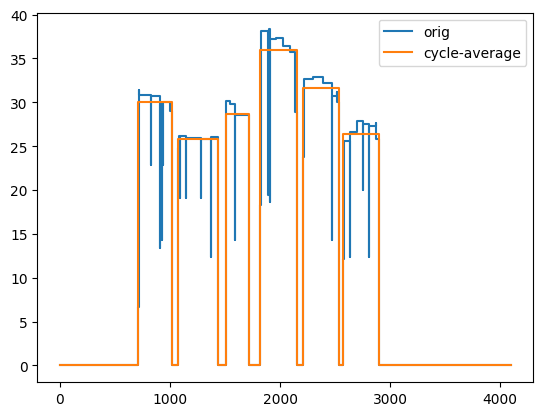

In [17]:
bh.plot_power_history(label='orig')
x = bh.classify_operations(min_shutdown_time=10.0)
new_time = bh.get_cycle_time(x)
bh2 = bh.regrid(new_time)
bh2.plot_power_history(label='cycle-average',add_to_existing=True)
burndata = []
for time,power in zip(bh2.interval_time,bh2.interval_power):
    burndata.append({"burn":time, "power":power})

#uncalibrated case
burndata_nocal = []
for time,power in zip(bh2.interval_time,bh2.interval_power):
    burndata_nocal.append({"burn":time, "power":power/power_calibration})

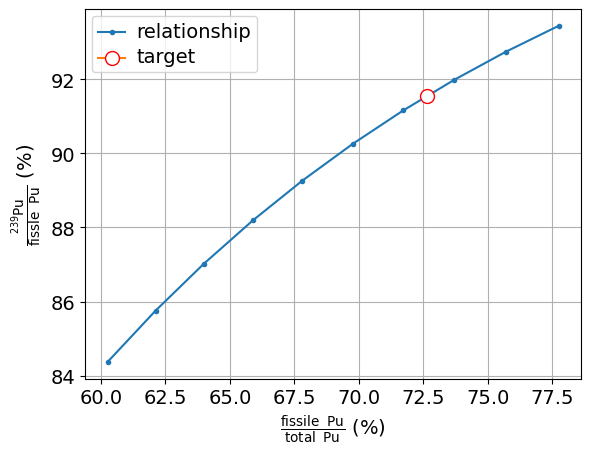

In [18]:
target_p=5.5
target_fp=72.64
xcomp = olm.contrib.sfcompo_guess_initial_mox(target_fp,target_p,am241=0.0, plot=True)

In [19]:
# Modify any isotopic components for sensitivity studies.
print(xcomp['puo2']['iso'])

{'pu238': 1.004872407301296, 'pu240': 22.994586017532153, 'pu241': 6.140090037926896, 'pu242': 3.3605521484973133, 'pu239': 66.49989938874234}


In [20]:
def get_contents(xcomp,burndata):
    tm=olm.core.TemplateManager()
    data={
        "_": {
            "env": {"work_dir": ""}, 
            "model": {"name": "mox_w14x14"}
        },
        "_arpinfo": {
            "interpvars": {
                "mod_dens": 0.75
            } 
        }, 
        "comp": {"system": xcomp }, 
        "history": {
            "initialhm": 1, 
            "burndata": burndata
        }
    }
    return tm.expand('model/origami/system-mox.jt.inp',data)
contents = get_contents(xcomp,burndata)
contents_nocal = get_contents(xcomp,burndata_nocal)

In [21]:
# Remove the link for this use case.
def content_patch(contents):
    i=contents.find("=shell")
    e=contents.find('=origami')
    contents = contents.replace(contents[i:e],'')
    contents = contents.replace('nlib=1','nlib=3')
    return contents
contents = content_patch(contents)
contents_nocal = content_patch(contents_nocal)
print(contents)

=origami

libs=[ mox_w14x14 ]

options{ ft71=all mtu=1 }

fuelcomp{
    stdcomp(c_uo2){ base=uo2 dens=10.4
        iso[
            92234=9.99999999998e-11
            92235=0.23099999999953796
            92236=9.99999999998e-11
            92238=99.76899999980047
        ]
    }
    stdcomp(c_puo2){ base=puo2 dens=10.4
        iso[
            94238=1.004872407301296
            94239=66.49989938874234
            94240=22.994586017532153
            94241=6.140090037926896
            94242=3.3605521484973133
        ]
    }
    stdcomp(c_am){ base=am  dens=10.4
        iso[
            95241=100.0
        ]
    }
    stdcomp(c_o2){ base=o  dens=10.4
    }
    mix(1){ comps[
        c_uo2 = 94.5000000000104
        c_puo2 = 5.499999999989605
        c_am = 4.8554667986940905e-22
        c_o2 = 6.445332012955142e-23
    ] }
}

modz = [ 0.75 ]
pz = [ 1.0 ]

hist[
  cycle{ power=0.0 burn=714.0 nlib=3 }
  cycle{ power=30.078964486548596 burn=307.79999999999995 nlib=3 }
  cycle{ power=0.

In [22]:
td = olm.core.TempDir()
path = td.write_file(contents,'origami.inp')
scalerte = scale_path + '/bin/scalerte'
sr = olm.core.ScaleRunner(scalerte)

In [23]:
input,results = sr.run(path)
print(json.dumps(results,indent=4))

{
    "returncode": 0,
    "success": true,
    "errors": [],
    "command_line": "/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/scalerte ",
    "input_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpab0u49vx/origami.inp",
    "output_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpab0u49vx/origami.out",
    "message_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpab0u49vx/origami.msg",
    "data_size": 109268059508,
    "scale_runtime_seconds": 30.79776406288147,
    "data_dir": "/Users/Shared/ornldev/code/scale/builds/master/INSTALL/data",
    "scalerte_path": "/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/scalerte",
    "input_file_hash": "b60cae4d9457156913a83144680ee0e9",
    "version": "7.0.pre-b7",
    "runtime_seconds": 30.798495054244995,
    "rerun": true
}


In [24]:
f71 = Path(results['input_file']).with_suffix('.f71')
print(f71,f71.exists())

/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpab0u49vx/origami.f71 True


In [25]:
def get_ii_json(f71):
    obiwan = scale_path + '/bin/obiwan'
    ii_json = olm.internal.run_command(f"{obiwan} view -format=ii.json -cases='[1]' {f71}",echo=False)
    return json.loads(ii_json)

In [26]:
base_ii = get_ii_json(f71)
base = olm.core.InventoryInterface(base_ii)
ni_base = base.nuclide_inventory('case(1)')

2023-10-09 18:36:26 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpab0u49vx/origami.f71


In [27]:
#run nocalibrated case
path_nocal = td.write_file(contents_nocal,'origami_nocal.inp')
input_nocal,results_nocal = sr.run(path_nocal)
f71_nocal = Path(results_nocal['input_file']).with_suffix('.f71')
base_ii_nocal = get_ii_json(f71_nocal)
base_nocal = olm.core.InventoryInterface(base_ii_nocal)
ni_base_nocal = base_nocal.nuclide_inventory('case(1)')

2023-10-09 18:36:57 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpab0u49vx/origami_nocal.f71


In [28]:
def parse_csv(path, delim=';'):
    lines = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            lines.append(line.split(delim))

    return lines

measurements = parse_csv('data/Beznau-1_M308_K7_BM5p_measurement.txt')
measurements = measurements[1:]
measured_fima = 0.0
total_u=0.0
total_pu=0.0
measured_mg_per_gHMi = {}
measured_pct_unc = {}
for m in measurements:
    if m[2].startswith('Burnup %FIMA'):
        measured_fima = float(m[6])/100.
    if not m[1].startswith('Other'):
        nuclide = m[2].lower()
        conc = float(m[8])
        measured_mg_per_gHMi[nuclide] = conc
        if nuclide.startswith('u'):
            total_u+=conc
        if nuclide.startswith('pu'):
            total_pu+=conc
        measured_pct_unc[nuclide] = float(m[10].replace('%',''))
print(measured_mg_per_gHMi)
print('fima=',measured_fima)

{'u234': 0.05638, 'u235': 0.6648, 'u236': 0.3051, 'u238': 905.2, 'np237': 0.2087, 'pu238': 1.129, 'pu239': 11.12, 'pu240': 11.46, 'pu241': 5.218, 'pu242': 4.163, 'pu244': 0.001134, 'am241': 1.282, 'am242m': 0.01202, 'am243': 1.063, 'cm242': 0.00169, 'cm243': 0.007827, 'cm244': 0.802, 'cm245': 0.09937, 'cm246': 0.01588, 'ce144': 0.01906, 'nd142': 0.03369, 'nd143': 1.18, 'nd144': 1.758, 'nd145': 0.954, 'nd146': 1.087, 'nd148': 0.6228, 'nd150': 0.3721, 'pm147': 0.08304, 'sm147': 0.2654, 'sm148': 0.3074, 'sm149': 0.004628, 'sm150': 0.4912, 'sm151': 0.02484, 'sm152': 0.1792, 'sm154': 0.1006, 'eu151': 0.0008803, 'eu153': 0.2643, 'eu154': 0.0574, 'eu155': 0.01531, 'gd155': 0.008326, 'sr90': 0.3562, 'mo95': 1.021, 'tc99': 1.099, 'ru101': 1.014, 'ru106': 0.2146, 'rh103': 0.6988, 'ag109': 0.1872, 'sb125': 0.008141, 'i129': 0.2541, 'cs133': 1.724, 'cs134': 0.08394, 'cs135': 1.18, 'cs137': 1.894}
fima= 0.056799999999999996


944962.6780439559 grams of U initial
55037.32195604415 grams of Pu initial
1000000.0000000001 grams of HM initial
hm_mass[0]= 1000000.0


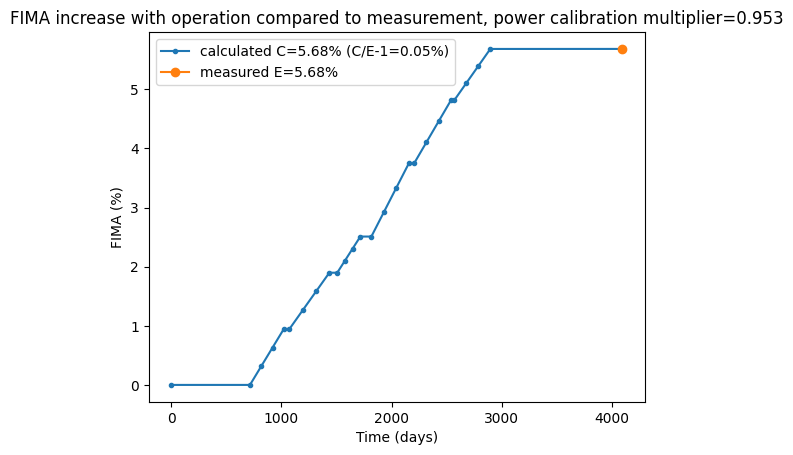

In [29]:
u_initial=0.0
pu_initial=0.0
cm = ni_base.composition_manager
for n,x in ni_base.nuclide_amount.items():
    eam = cm.eam(n)
    if eam.startswith('u'):
        u_initial+=x[0]*cm.mass(n)
    if eam.startswith('pu'):
        pu_initial+=x[0]*cm.mass(n)
hm_initial = u_initial+pu_initial
scale = 1e3 / hm_initial #mg/gHMi
print(u_initial,'grams of U initial')
print(pu_initial,'grams of Pu initial')
print(hm_initial,'grams of HM initial')
hm_mass = ni_base.get_hm_mass()
print('hm_mass[0]=',hm_mass[0])
fima = 1.0-hm_mass/hm_mass[0]
plt.plot(ni_base.time/86400.,100*fima,label='calculated C={:.2f}% (C/E-1={:.2f}%)'.format(100*fima[-1],100*(fima[-1]/measured_fima-1)),marker='o',markersize=3)
plt.errorbar([ni_base.time[-1]/86400.],[100*measured_fima],marker='o',label='measured E={:.2f}%'.format(100*measured_fima))
plt.ylabel('FIMA (%)')
plt.xlabel('Time (days)')
plt.title('FIMA increase with operation compared to measurement, power calibration multiplier={:.3f}'.format(power_calibration))
plt.legend()
plt.show()

[-3.21157360e-10 -3.08045453e-05 -3.07565679e-05 -3.07216929e-05
 -3.53391458e-09 -2.62860971e-05 -2.62549405e-05 -2.62245567e-05
 -5.01866714e-09 -2.91844386e-05 -2.91620606e-05 -2.91408579e-05
 -6.05456015e-09 -3.64193749e-05 -3.63672355e-05 -3.63148616e-05
 -1.06922260e-08 -3.19370380e-05 -3.18957968e-05 -3.18555293e-05
 -1.20861226e-08 -2.65410911e-05 -2.65126585e-05 -2.64854909e-05
 -4.09770282e-09]


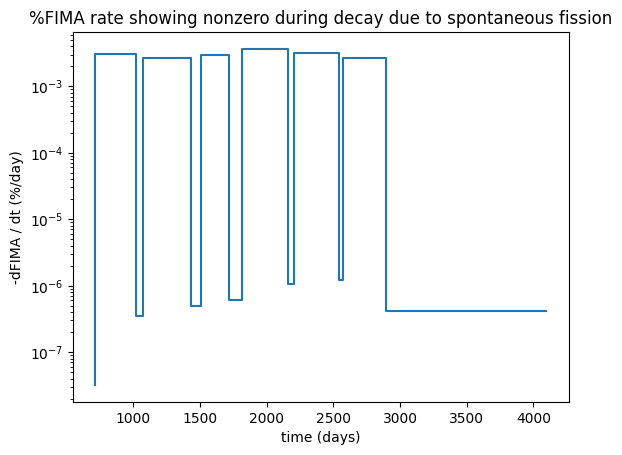

In [30]:
dt=np.diff(ni_base.time/86400.)
dh=np.diff(hm_mass/hm_mass[0])
print(dh/dt)
coeff = -dh/dt
plt.step(ni_base.time[1:]/86400,100*coeff,where='pre')
plt.yscale('log')
plt.ylabel('-dFIMA / dt (%/day)')
plt.xlabel('time (days)')
plt.title('%FIMA rate showing nonzero during decay due to spontaneous fission')
plt.show()

cumulative loss 80<=Z<=90 -> 0.000 grams
cumulative loss 80<=Z<=91 -> 0.000 grams
cumulative loss 80<=Z<=92 -> 32.386 grams
cumulative loss 80<=Z<=93 -> 22.118 grams
cumulative loss 80<=Z<=94 -> 660.284 grams
cumulative loss 80<=Z<=95 -> 250.073 grams
cumulative loss 80<=Z<=96 -> 4.912 grams
cumulative loss 80<=Z<=97 -> 4.912 grams
cumulative loss 80<=Z<=98 -> 4.912 grams
cumulative loss 80<=Z<=99 -> 4.912 grams
The main way to lose mass is spontaneous fission. Should this count as FIMA or not?


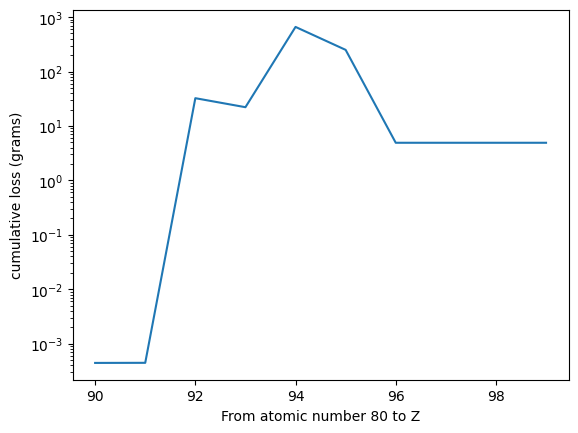

In [31]:
# Show heavy metal mass lost cumulative from Z=80 to higher actinides.
# Once you include curium z=96 you can see there is some mlist=[]
zlist=[90,91,92,93,94,95,96,97,98,99]
mlist=[]
for z in zlist:
    xhm_mass = ni_base.get_hm_mass(min_z=80,max_z=z)
    mlist.append(np.abs(xhm_mass[-2]-xhm_mass[-1]))
for f in ["cumulative loss 80<=Z<={} -> {:.3f} grams".format(z,m) for z,m in zip(zlist,mlist)]:
    print(f)
print("The main way to lose mass is spontaneous fission. Should this count as FIMA or not?")
plt.semilogy(zlist,mlist)
plt.xlabel('From atomic number 80 to Z')
plt.ylabel('cumulative loss (grams)')
plt.show()

In [32]:
def ns001():
    nuclide_sets = []
    nuclide_sets.append( ['tc99', 'cs134','cs137','nd145','nd148','eu154'] )
    nuclide_sets.append( ['u238'] )
    nuclide_sets.append( ['u234','u235','u236'] )
    nuclide_sets.append( ['cm242','cm244','am241','am242m','am243'] )
    nuclide_sets.append( ['pu238','pu239','pu240','pu241','pu242'] )
    return nuclide_sets
def ns002():
    s1=['cm242','pu238','u234','th230']
    s2=['cm244','pu240','u236','th232']
    return [s1,s2]

tc99    : calculated C=1.27e+00 g/gHMi, measured E=1.10e+00 g/gHMi +/- 2.14e-01 (19.47%), C/E-1=15.52%
cs134   : calculated C=7.25e-02 g/gHMi, measured E=8.39e-02 g/gHMi +/- 2.59e-03 (3.09%), C/E-1=-13.60%
cs137   : calculated C=1.86e+00 g/gHMi, measured E=1.89e+00 g/gHMi +/- 5.76e-02 (3.04%), C/E-1=-1.95%
nd145   : calculated C=9.39e-01 g/gHMi, measured E=9.54e-01 g/gHMi +/- 5.34e-03 (0.56%), C/E-1=-1.53%
nd148   : calculated C=6.15e-01 g/gHMi, measured E=6.23e-01 g/gHMi +/- 3.49e-03 (0.56%), C/E-1=-1.24%
eu154   : calculated C=6.18e-02 g/gHMi, measured E=5.74e-02 g/gHMi +/- 1.73e-03 (3.01%), C/E-1=7.63%


NameError: name 'ind' is not defined

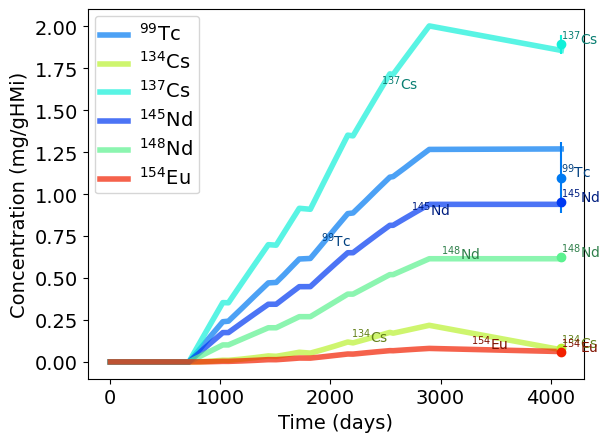

In [33]:
# Now we have all data loaded into memory.
# Let's make some plots.
nuclide_sets = ns001()
nuclide_sets.append(list(measured_mg_per_gHMi.keys()))
amount_map = {}
amount_err = {}
ind=0
for nuclide_list in nuclide_sets:
    amount = ni_base.plot_nuclide_amounts(nuclide_list,amount_mult=scale,linewidth=4,alpha=0.7)
    amount_map.update( amount )
    plt.ylabel('Concentration (mg/gHMi)')
    olm.contrib.change_plot_font_size(plt.gca(),14)
    w=0.4
    ind+=1
    for nuclide in nuclide_list:
        w+=0.4/len(nuclide_list)
        tm=ni_base.time[-1]*(w) + (1-w)*ni_base.time[0]
        ym = np.interp(tm,ni_base.time,amount[nuclide])
        color = ni_base._nuclide_color(cm.izzzaaa(nuclide),weight=0.5)
        label = ni_base._nice_label(nuclide)
        plt.annotate(label,xy=(tm/86400.,ym),xycoords='data',color=color)
        if nuclide in measured_mg_per_gHMi:
            t=ni_base.time[-1]/86400.
            e=float(measured_mg_per_gHMi[nuclide])
            c = amount_map[nuclide][-1]
            relunc_e = float(measured_pct_unc[nuclide])/100.
            unc_e = relunc_e*e
            err = (c/e-1.0)
            amount_err[nuclide]=(err,relunc_e)
            print("{:8s}: calculated C={:.2e} g/gHMi, measured E={:.2e} g/gHMi +/- {:.2e} ({:.2f}%), C/E-1={:.2f}%".format(nuclide,c,e,unc_e,100*relunc_e,100*err))
            plt.errorbar([t],[e], yerr=unc_e, fmt='o', color=ni_base._nuclide_color(cm.izzzaaa(nuclide)))
            plt.annotate(label,xy=(t,e),xycoords='data',color=color)
    plt.savefig('beznau1-m308-k7-comp'+str(ind)+'.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
for nuclide in ['nd148','cs134','cs137']:
    color = ni_base._nuclide_color(cm.izzzaaa(nuclide),weight=0.8)
    label = ni_base._nice_label(nuclide)
    dark_color = [0.5*c for c in color]
    dark_color[3]=1.0
    plt.plot(100*fima,amount_map[nuclide],label=ni_base._nice_label(nuclide), marker='.',color=color,linewidth=4,alpha=0.7)
    if nuclide in measured_mg_per_gHMi:
        plt.errorbar(100*measured_fima,float(measured_mg_per_gHMi[nuclide]),marker='o', color=color)
    fm=0.5*(fima[0]+fima[-1])
    ym=np.interp(fm,fima,amount_map[nuclide])
    plt.annotate(label,xy=(100*fm,ym),xycoords='data',color=dark_color, xytext=(-30, 30), ha='center', va='top', textcoords='offset points', arrowprops=dict(color='k', arrowstyle="->"))
plt.legend()
plt.xlabel('FIMA (%)')
plt.ylabel('Concentration (mg/gHMi)')
plt.show()

time=ni_base.time/86400.
for nuclide in ['nd148','cs134','cs137']:
    color = ni_base._nuclide_color(cm.izzzaaa(nuclide),weight=0.8)
    dark_color = [0.5*c for c in color]
    dark_color[3]=1.0
    label = ni_base._nice_label(nuclide)
    plt.plot(time,amount_map[nuclide],label=label, marker='.', color=color,linewidth=4,alpha=0.7)
    if nuclide in measured_mg_per_gHMi:
        plt.errorbar(time[-1],float(measured_mg_per_gHMi[nuclide]),marker='o', color=color)
    tm=0.5*(time[0]+time[-1])
    ym=np.interp(tm,time,amount_map[nuclide])
    plt.annotate(label,xy=(tm,ym),xycoords='data',color=dark_color, xytext=(-30, 30), ha='center', va='top', textcoords='offset points', arrowprops=dict(color='k', arrowstyle="->"))
        
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Concentration (mg/gHMi)')
plt.show()
print('power correction to calibrate to measured FIMA: power_factor=',measured_fima/fima[-1])
print('power correction to calibrate to measured Nd-148: power_factor=',measured_mg_per_gHMi['nd148']/amount_map['nd148'][-1])

In [26]:
import copy
time = [0]
time.extend( np.cumsum(bh2.interval_time) )
power_uncertainty = 0.10
nperts = len(bh2.interval_power)*(nreal+1)
power_perts = np.random.uniform(1.0-power_uncertainty,1.0+power_uncertainty,size=nperts)
i=0
bh_list = []
print('generating',nreal,'realizations')
for j in range(nreal):
    power = copy.deepcopy(bh2.interval_power)
    for k in range(len(power)):
        power[k]*=power_perts[i]
        i+=1
    burnup = [0]
    burnup.extend( np.cumsum(power*np.asarray(bh2.interval_time)) )
    bh_list.append( olm.core.BurnupHistory(time,burnup) )

generating 300 realizations


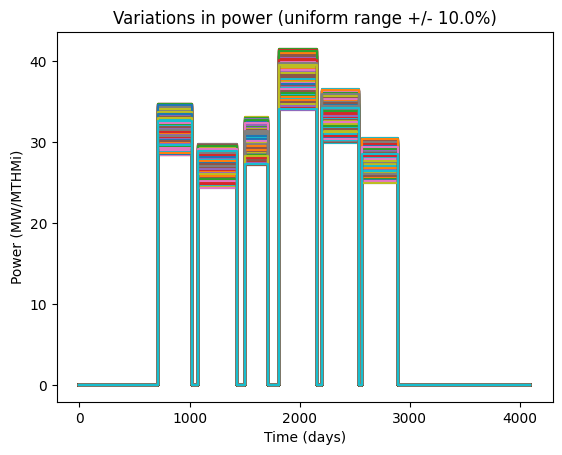

In [27]:
j=0
for bh in bh_list:
    bh.plot_power_history(label=str(j+1),add_to_existing=j!=0)
    j+=1
plt.title("Variations in power (uniform range +/- {:.1f}%)".format(100*power_uncertainty))
plt.gca().get_legend().remove()
plt.xlabel('Time (days)')
plt.ylabel('Power (MW/MTHMi)')
plt.show()

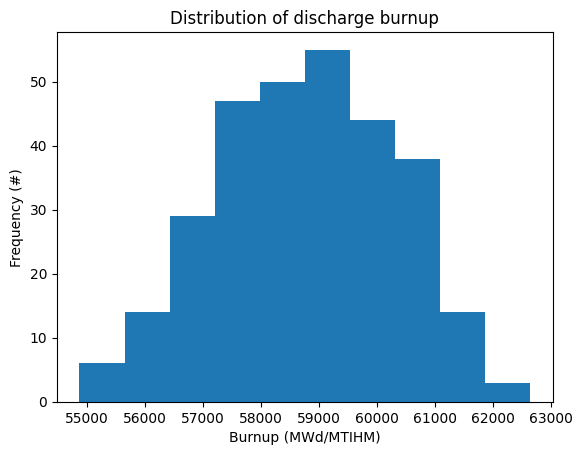

In [28]:
discharge_burnup=[]
for bh in bh_list:
    discharge_burnup.append( bh.burnup[-1] )
    j+=1
plt.hist(discharge_burnup)
plt.xlabel('Burnup (MWd/MTIHM)')
plt.ylabel('Frequency (#)')
plt.title('Distribution of discharge burnup')
plt.show()

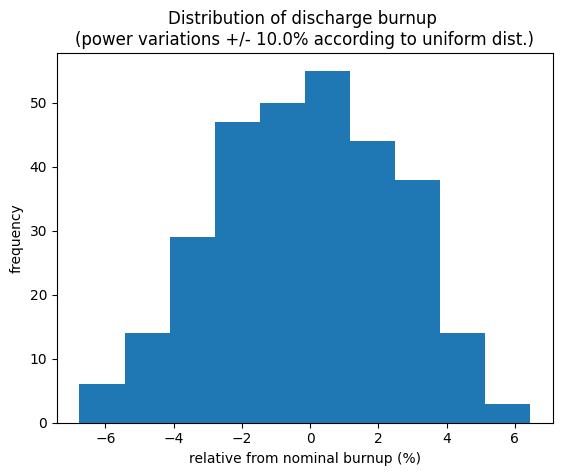

In [29]:
plt.hist(100*(discharge_burnup/bh2.burnup[-1] - 1))
plt.xlabel('relative from nominal burnup (%)')
plt.ylabel('frequency')
plt.title("Distribution of discharge burnup \n(power variations +/- {:.1f}% according to uniform dist.)".format(100*power_uncertainty))
plt.show()
# Note that sum of uniform distributions is 
# an Irwin-Hall distribution: https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution

In [30]:
# Create all the inputs.
j=0
input_list=[]
for bh in bh_list:
    j+=1
    burndata = []
    for time,power in zip(bh.interval_time,bh.interval_power):
        burndata.append({"burn":time, "power":power})
    contents = get_contents(xcomp,burndata)
    path = td.write_file(contents,"origami{:03d}.inp".format(j))
    input_list.append(path)

In [31]:
# Create a thread executor.
num_workers=6
tpe = olm.core.ThreadPoolExecutor(max_workers=num_workers)

In [32]:
results = tpe.execute(sr.run,input_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:11<00:00,  1.24s/it]


In [33]:
for r in results:
    print(r)

/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami004.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami003.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami005.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami002.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami001.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami006.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami012.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami009.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami007.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami010.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami008.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami011.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami013.inp
/var/folders

In [34]:
f71_list = []
for r in results:
    f71_list.append( Path(results[r]['input_file']).with_suffix('.f71') )

In [35]:
def ii_json_runner(input_f71):
    return input_f71, get_ii_json(input_f71)
results_ii = tpe.execute(ii_json_runner,f71_list)

  0%|                                                                                                                                                           | 0/300 [00:00<?, ?it/s]2023-10-04 20:00:49 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/tri14/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami004.f71
2023-10-04 20:00:49 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/tri14/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami003.f71
2023-10-04 20:00:49 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/tri14/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpf1guzf6t/origami005.f71
2023-10-04 20:00:49 [info     ] Running external               command_line=/Users/S

In [36]:
xx=dict()
for k,v in results_ii.items():
    xx[k.stem] = olm.core.InventoryInterface(v).nuclide_inventory('case(1)') 

In [37]:
import matplotlib.patches as mpatches
alpha0=0.8
linewidth0=10
time = ni_base.time/86400.
for nuclide in measured_mg_per_gHMi:
#for nuclide in ['tc99']:
    c0 = ni_base.get_amount(nuclide,units="GRAMS")
    handles=[]
    color = olm.core.NuclideInventory._nuclide_color(ni_base.composition_manager.izzzaaa(nuclide))
    label = ni_base._nice_label(nuclide)
    dark_color = [0.7*c for c in color]
    dark_color[-1] = 1.0
    handles.append(mpatches.Patch(color=color,label=label))
    min_z=np.zeros(len(ni_base.time))
    max_z=np.zeros(len(ni_base.time))
    for k,v in xx.items():
        z=100*v.rel_diff(nuclide,ni_base,units="GRAMS")
        min_z = np.minimum(min_z,z)
        max_z = np.maximum(max_z,z)
        plt.plot(time,
                 z, alpha=alpha0/(1+0.03*len(xx)),
                 color=color, linewidth=linewidth0/(1+0.03*len(xx)) )
    plt.plot(time, max_z, color='k', linewidth=1 )
    plt.plot(time, min_z, color='k', linewidth=1 )
    plt.plot(time, np.zeros(len(min_z)), color='k', linewidth=2 )

    z = 100*ni_base_nocal.rel_diff(nuclide,ni_base,units="GRAMS")
    plt.plot(time, z, linestyle=":", color='k')
    tm = 0.5*(time[0]+time[-1])
    ym = np.interp(tm,time,z)
    plt.annotate('uncalibrated',xy=(tm,ym), xytext=(-30, 30), ha='center', va='top', textcoords='offset points', arrowprops=dict(color='k', arrowstyle="->"))
    max_i = np.argmax(max_z)
    max_s = max_z[max_i] 
    mg_max = (max_s/100+1)*c0[max_i]/1000
    #plt.annotate("Calc. max.\n{:.3e}".format(mg_max),xy=(time[max_i],max_s), color=dark_color, xytext=(0, -40), ha='center', va='bottom', textcoords='offset points', arrowprops=dict(color=dark_color, arrowstyle="->"))
                        
    min_i = np.argmin(min_z)
    min_s = min_z[min_i]
    mg_min = (min_s/100+1)*c0[min_i]/1000
    #plt.annotate("Calc. min.\n{:.3e}".format(mg_min),xy=(time[min_i],min_s), color=dark_color, xytext=(0, +40), ha='center', va='top', textcoords='offset points', arrowprops=dict(color=dark_color, arrowstyle="->"))
                        
    relunc_e = amount_err[nuclide][1]
    e = measured_mg_per_gHMi[nuclide]
    c0_mg = c0[-1]/1000
    max_abs = (max_z[-1]/100+1)*c0_mg
    min_abs = (min_z[-1]/100+1)*c0_mg
    drel = max_z[-1] - min_z[-1]
    dabs = max_abs - min_abs

    def y1_to_y2(x):
        return min_abs + (dabs/drel) * (x-min_z[-1])
        
    def y2_to_y1(x):
        return min_z[-1] + (drel/dabs) * (x-min_abs)

    e1 = y2_to_y1(e)
    secax = plt.gca().secondary_yaxis('right', functions=(y1_to_y2, y2_to_y1))
    secax.set_ylabel("Final Concentration (mg/gHMi)")
    t=time[-1]
    secax.axes.errorbar([t],[e1], yerr=100*relunc_e, fmt='o', color=dark_color)
    secax.axes.annotate("Measured\n{:.3e}".format(e),xy=(t,e1), xytext=(-80,-10), color=dark_color, ha='left', va='center', textcoords='offset points', arrowprops=dict(color=dark_color, arrowstyle="->"))
    plt.legend(handles=handles,loc='upper left')
    plt.xlabel("Time (days)")
    plt.ylabel(r"rel. diff. $C'/C_0 - 1$ (%)")
    plt.gca().tick_params(axis='y', colors='k')
    plt.gca().yaxis.label.set_color('k')
    secax.tick_params(axis='y', colors=dark_color)
    secax.yaxis.label.set_color(dark_color)
    #plt.xlim([time[0],time[-1]*1.1])
    #plt.ylim([-100*power_uncertainty,100*power_uncertainty])
    olm.contrib.change_plot_font_size(plt.gca(),14)
    plt.grid()
    plt.show()

ValueError: operands could not be broadcast together with shapes (14,) (26,) 